In [ ]:
!pip install skillsnetwork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import skillsnetwork
import json
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


In [ ]:
data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/data/data.json"
raw_data = await skillsnetwork.read(data_url)
data = json.loads(raw_data)
df = pd.DataFrame(data).set_index("id")

In [ ]:
df.shape

(39774, 2)

In [ ]:
df.sample(5)

,cuisine,ingredients
id,,
33347,italian,"[grated lemon zest, pizza doughs, ricotta, asp..."
9077,chinese,"[low sodium soy sauce, water, ground black pep..."
5085,brazilian,"[garlic, long-grain rice, water, hot sauce, ol..."
11758,japanese,"[minced garlic, salt, snow peas, low sodium so..."
35944,italian,"[pesto, spaghetti, lemon, almonds, spinach, ed..."


In [ ]:
df["cuisine"].unique().tolist()

['greek',
 'southern_us',
 'filipino',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'chinese',
 'british',
 'thai',
 'vietnamese',
 'cajun_creole',
 'brazilian',
 'french',
 'japanese',
 'irish',
 'korean',
 'moroccan',
 'russian']

In [ ]:
len(df["cuisine"].unique())

20

<Axes: >

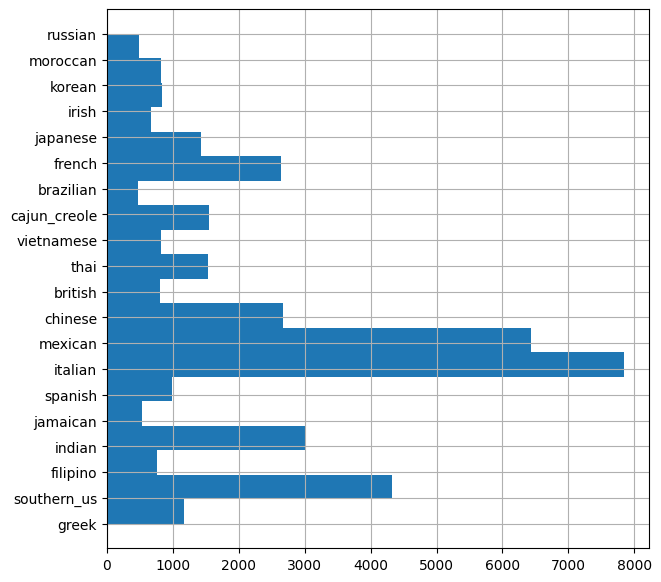

In [ ]:
df["cuisine"].hist(orientation='horizontal', bins=20, figsize=(7,7))

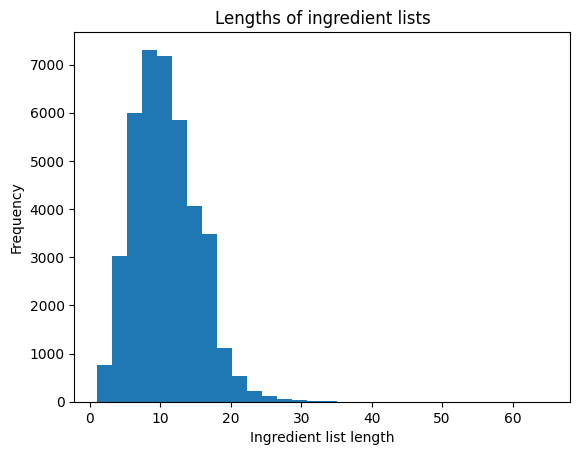

In [ ]:
plt.hist(df['ingredients'].apply(lambda x: len(x)), bins = 30)
plt.title("Lengths of ingredient lists")
plt.xlabel("Ingredient list length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
all_ingredients = df['ingredients'].explode()
all_ingredients

id
10259    romaine lettuce
10259       black olives
10259     grape tomatoes
10259             garlic
10259             pepper
              ...       
2362              garlic
2362         white sugar
2362       roma tomatoes
2362              celery
2362       dried oregano
Name: ingredients, Length: 428275, dtype: object

In [ ]:
ingredients = all_ingredients.unique()
len(ingredients)

6714

In [ ]:
# Inggredients from the first dish in training data
df.loc[0,'ingredients']

['mussels',
 'ground black pepper',
 'garlic cloves',
 'saffron threads',
 'olive oil',
 'stewed tomatoes',
 'arborio rice',
 'minced onion',
 'medium shrimp',
 'fat free less sodium chicken broth',
 'green peas']

In [ ]:
# Converted the list into one string
df['ingredients'].astype(str)[0].strip('[]')

"'mussels', 'ground black pepper', 'garlic cloves', 'saffron threads', 'olive oil', 'stewed tomatoes', 'arborio rice', 'minced onion', 'medium shrimp', 'fat free less sodium chicken broth', 'green peas'"

In [ ]:
#grab the training set ingredients
ingredients = df['ingredients'].astype(str).apply(lambda x: x.strip('[]'))

cv = CountVectorizer(ngram_range=(1,2), max_features=200)
tf = cv.fit_transform(ingredients)

df_vectorized = pd.DataFrame(tf.toarray(), columns=cv.get_feature_names_out())
df_vectorized

,all,all purpose,avocado,baking,baking powder,basil,bay,beans,beef,bell,...,vegetable oil,vinegar,virgin,virgin olive,water,white,white wine,whole,wine,yellow
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,2,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [ ]:
# Lets just look at the top 10
cv.get_feature_names_out()[:10]

array(['all', 'all purpose', 'avocado', 'baking', 'baking powder',
       'basil', 'bay', 'beans', 'beef', 'bell'], dtype=object)

In [ ]:
# I've taken the liberty of removing these features,
# although you can add or remove features to this list as you see fit!

excludedWords = ['all', 'all purpose', 'baking', 'brown', 'cooked', 'cooking', 'diced', 'dried', 'dry',
                 'extra', 'extra virgin', 'extract', 'grated', 'green', 'ground', 'heavy', 'hot',
                 'italian', 'kosher', 'large', 'low', 'minced', 'light', 'powder', 'purple', 'purpose',
                 'purpose flour', 'red', 'sea', 'skinless', 'sliced', 'sodium chicken','sour','unsalted',
                 'virgin', 'white','whole','yellow']

In [ ]:
df_vectorized.drop(columns=excludedWords, inplace=True)

In [ ]:
df_vectorized.head()

,avocado,baking powder,basil,bay,beans,beef,bell,bell pepper,black,black pepper,...,unsalted butter,vanilla,vanilla extract,vegetable,vegetable oil,vinegar,virgin olive,water,white wine,wine
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# TODO: Use the train_test_split() function twice in order to split the data into 75% training and 25% testing data
x_train, x_test, y_train, y_test = train_test_split(df_vectorized, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

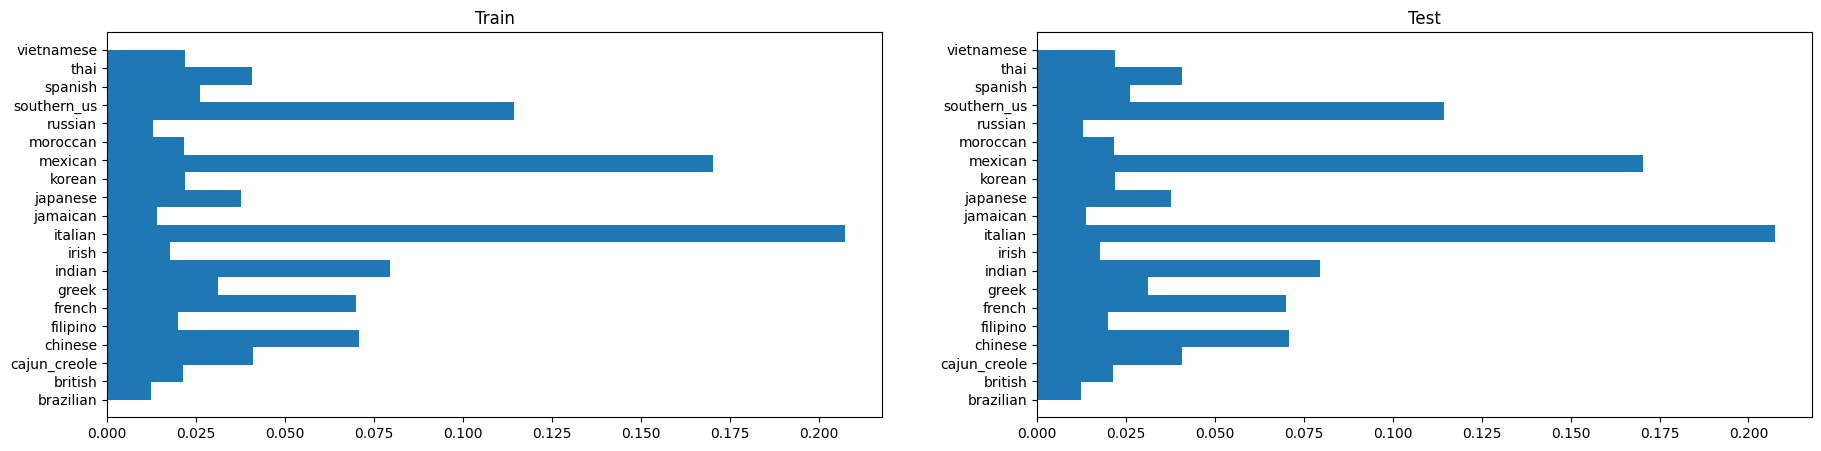

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(22,5))

ax[0].hist(y_train.sort_values(),orientation='horizontal', bins=20, density=True)
ax[1].hist(y_test.sort_values(),orientation='horizontal', bins=20, density=True)
ax[0].set_title('Train')
ax[1].set_title('Test')
fig.show()

In [ ]:
lr = LogisticRegression(multi_class="multinomial").fit(x_train, y_train)
print(classification_report(y_test, lr.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.49      0.27      0.35       117
     british       0.36      0.17      0.23       201
cajun_creole       0.72      0.59      0.65       386
     chinese       0.71      0.78      0.74       668
    filipino       0.60      0.44      0.51       189
      french       0.47      0.46      0.47       662
       greek       0.61      0.41      0.49       294
      indian       0.79      0.78      0.78       751
       irish       0.51      0.31      0.38       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.65      0.44      0.53       131
    japanese       0.51      0.43      0.47       356
      korean       0.74      0.66      0.70       207
     mexican       0.84      0.86      0.85      1610
    moroccan       0.70      0.65      0.68       205
     russian       0.53      0.29      0.37       122
 southern_us       0.48      0.63      0.55      1080
     spanish       0.46    

<Axes: >

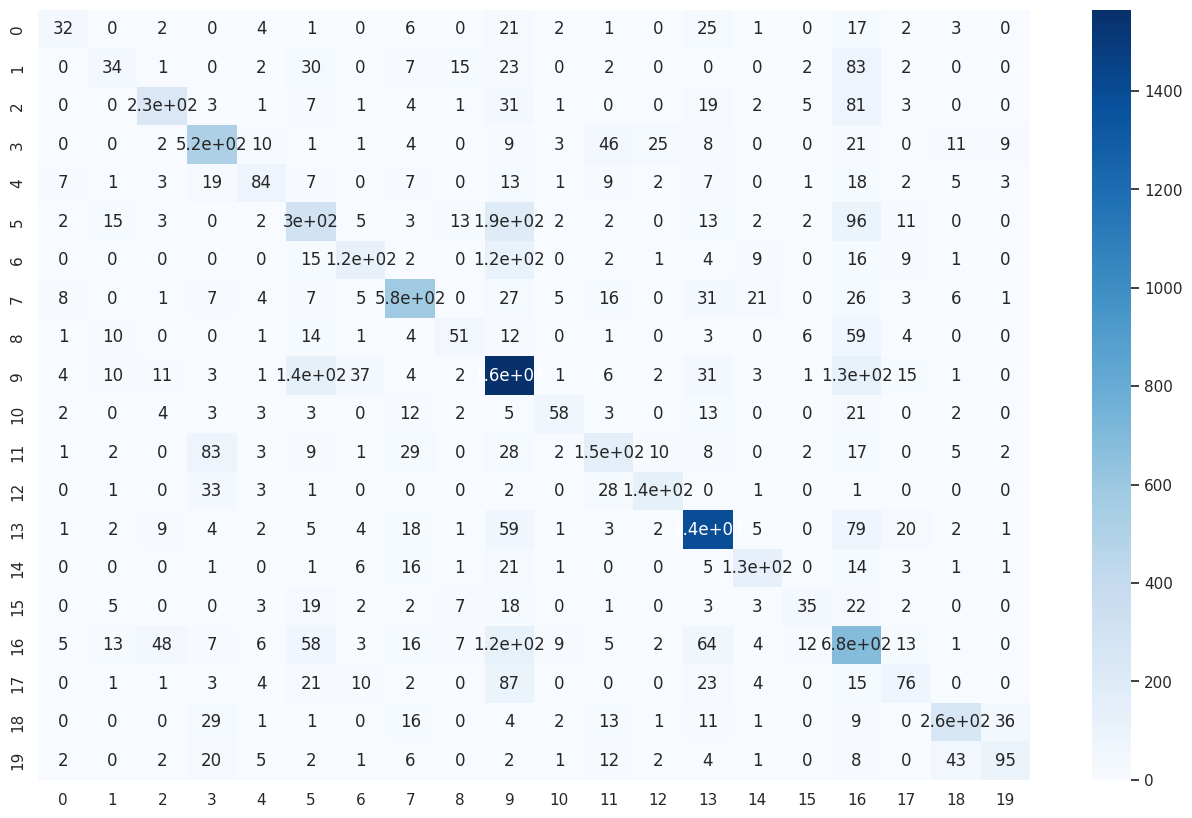

In [ ]:
conf_mat = confusion_matrix(y_test, lr.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [ ]:
lr_cv = LogisticRegressionCV(cv=5).fit(x_train, y_train)

In [ ]:
print(classification_report(y_test, lr_cv.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.57      0.26      0.36       117
     british       0.36      0.16      0.22       201
cajun_creole       0.73      0.59      0.65       386
     chinese       0.71      0.78      0.75       668
    filipino       0.63      0.43      0.51       189
      french       0.47      0.47      0.47       662
       greek       0.61      0.40      0.49       294
      indian       0.79      0.78      0.79       751
       irish       0.54      0.31      0.39       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.70      0.44      0.54       131
    japanese       0.51      0.44      0.47       356
      korean       0.78      0.68      0.72       207
     mexican       0.84      0.87      0.85      1610
    moroccan       0.71      0.63      0.67       205
     russian       0.57      0.28      0.37       122
 southern_us       0.48      0.64      0.55      1080
     spanish       0.46    

<Axes: >

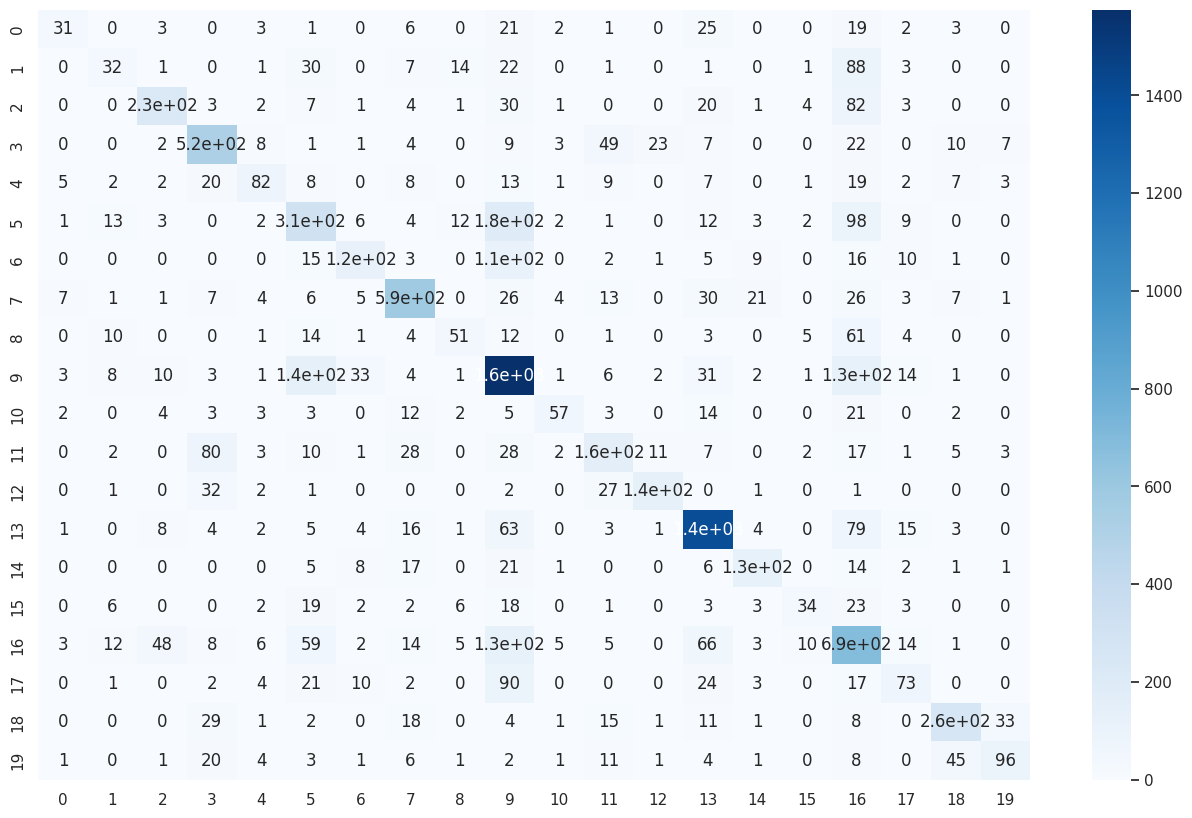

In [ ]:
conf_mat = confusion_matrix(y_test, lr_cv.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [ ]:

# Increase the number of features
cv_lg = CountVectorizer(ngram_range=(1,2), max_features=1000)
tf_lg = cv_lg.fit_transform(ingredients)
df_lg = pd.DataFrame(tf_lg.toarray(), columns=cv_lg.get_feature_names_out())
x_train_lg, x_test_lg, y_train_lg, y_test_lg = train_test_split(df_lg, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

# Fit to the Logistic Regression model
lr_cv_lg = LogisticRegression().fit(x_train_lg, y_train_lg)

# Print results
print(classification_report(y_test_lg, lr_cv_lg.predict(x_test_lg)))

              precision    recall  f1-score   support

   brazilian       0.55      0.53      0.54       117
     british       0.46      0.35      0.40       201
cajun_creole       0.75      0.69      0.72       386
     chinese       0.76      0.83      0.79       668
    filipino       0.64      0.53      0.58       189
      french       0.51      0.57      0.54       662
       greek       0.69      0.67      0.68       294
      indian       0.85      0.85      0.85       751
       irish       0.53      0.47      0.50       167
     italian       0.78      0.84      0.81      1960
    jamaican       0.76      0.60      0.67       131
    japanese       0.67      0.61      0.64       356
      korean       0.80      0.77      0.79       207
     mexican       0.88      0.90      0.89      1610
    moroccan       0.75      0.67      0.71       205
     russian       0.66      0.48      0.56       122
 southern_us       0.68      0.71      0.69      1080
     spanish       0.55    

<Axes: >

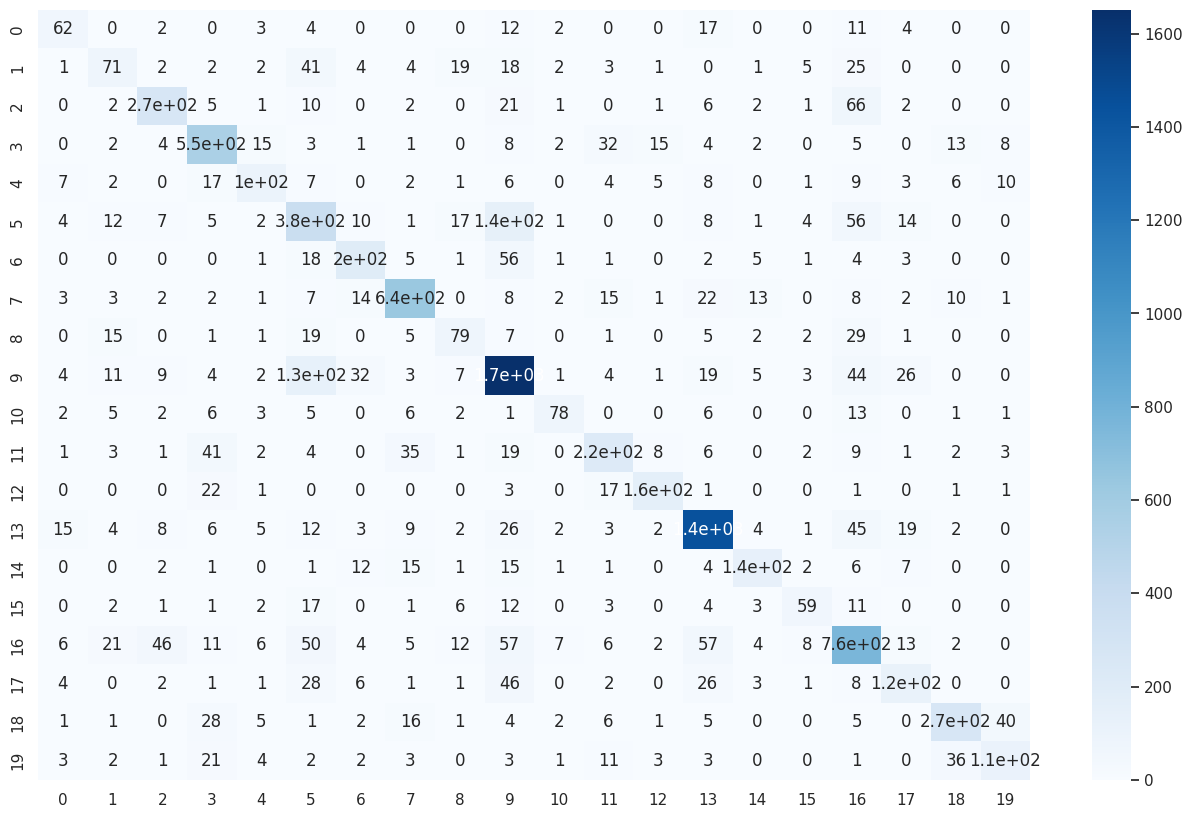

In [ ]:
conf_mat = confusion_matrix(y_test_lg, lr_cv_lg.predict(x_test_lg))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [ ]:
# We adjusted the size of our features using the ngram_range argument
cv_lg_oneword = CountVectorizer(ngram_range=(1,1), max_features=1000)
tf = cv_lg_oneword.fit_transform(ingredients)

df_oneword = pd.DataFrame(tf.toarray(), columns=cv_lg_oneword.get_feature_names_out())
df_oneword

x_train, x_test, y_train, y_test = train_test_split(df_oneword, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])
lr_cv = LogisticRegression().fit(x_train, y_train)

print(classification_report(y_test, lr_cv.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.66      0.56      0.61       117
     british       0.57      0.43      0.49       201
cajun_creole       0.78      0.71      0.74       386
     chinese       0.77      0.85      0.81       668
    filipino       0.69      0.58      0.63       189
      french       0.58      0.64      0.61       662
       greek       0.72      0.73      0.72       294
      indian       0.85      0.86      0.86       751
       irish       0.64      0.58      0.61       167
     italian       0.80      0.87      0.84      1960
    jamaican       0.81      0.67      0.74       131
    japanese       0.75      0.66      0.70       356
      korean       0.82      0.81      0.82       207
     mexican       0.89      0.91      0.90      1610
    moroccan       0.82      0.70      0.76       205
     russian       0.68      0.54      0.60       122
 southern_us       0.72      0.76      0.74      1080
     spanish       0.59    

<Axes: >

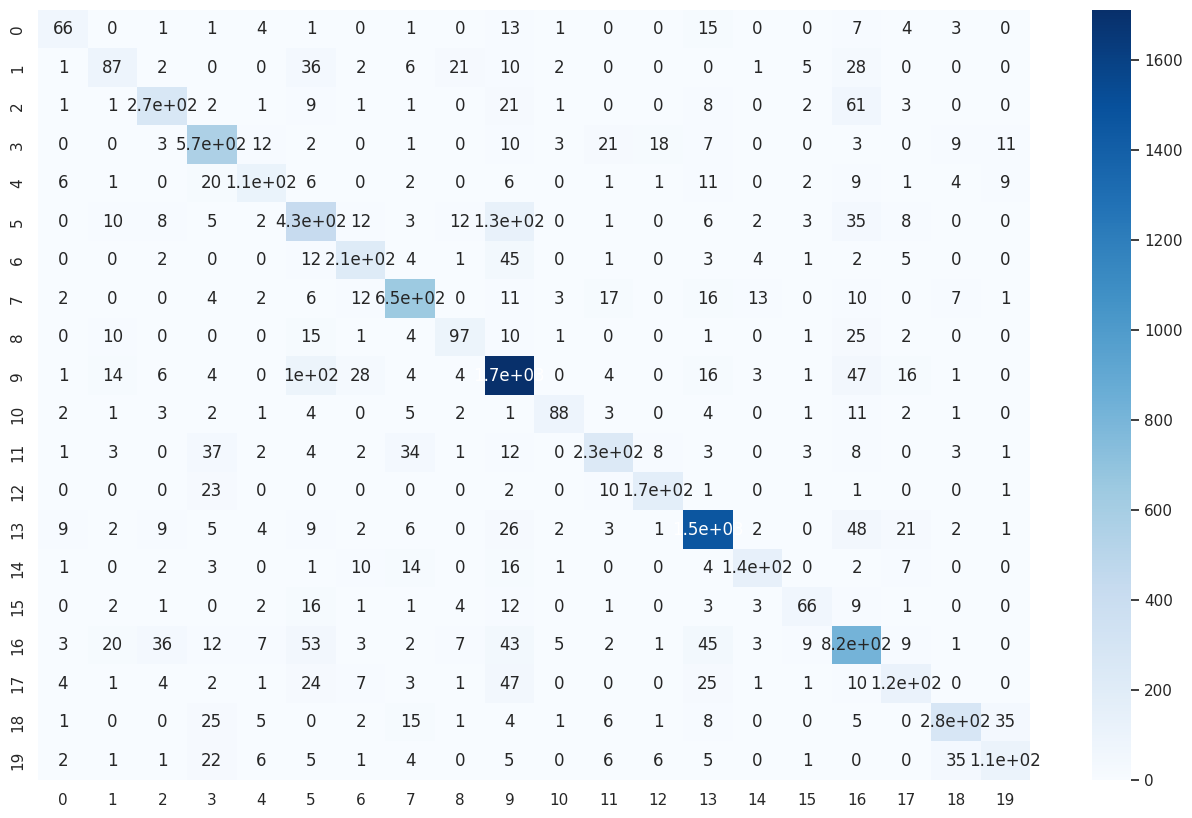

In [ ]:
conf_mat = confusion_matrix(y_test, lr_cv.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [ ]:
# We need to pick the number of features we want to reduce to
components = 200

pca = PCA(n_components=components, random_state=1)
svd = TruncatedSVD(n_components=components, random_state=1)
df_pca = pca.fit_transform(df_oneword)
df_svd = svd.fit_transform(df_oneword)

In [ ]:
x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(df_pca, df['cuisine'], test_size=0.25, random_state=1, stratify=df['cuisine'])

# Fit to the Logistic Regression model
lr_cv_sm = LogisticRegression().fit(x_train_sm, y_train_sm)

print(classification_report(y_test_sm, lr_cv_sm.predict(x_test_sm)))

              precision    recall  f1-score   support

   brazilian       0.49      0.36      0.41       117
     british       0.46      0.27      0.34       201
cajun_creole       0.77      0.67      0.71       386
     chinese       0.78      0.82      0.80       668
    filipino       0.64      0.50      0.56       189
      french       0.54      0.55      0.54       662
       greek       0.71      0.66      0.68       294
      indian       0.86      0.85      0.85       751
       irish       0.52      0.37      0.43       167
     italian       0.75      0.85      0.80      1960
    jamaican       0.77      0.53      0.63       131
    japanese       0.69      0.61      0.65       356
      korean       0.80      0.75      0.78       207
     mexican       0.86      0.89      0.88      1610
    moroccan       0.76      0.71      0.73       205
     russian       0.61      0.46      0.52       122
 southern_us       0.60      0.70      0.65      1080
     spanish       0.56    

<Axes: >

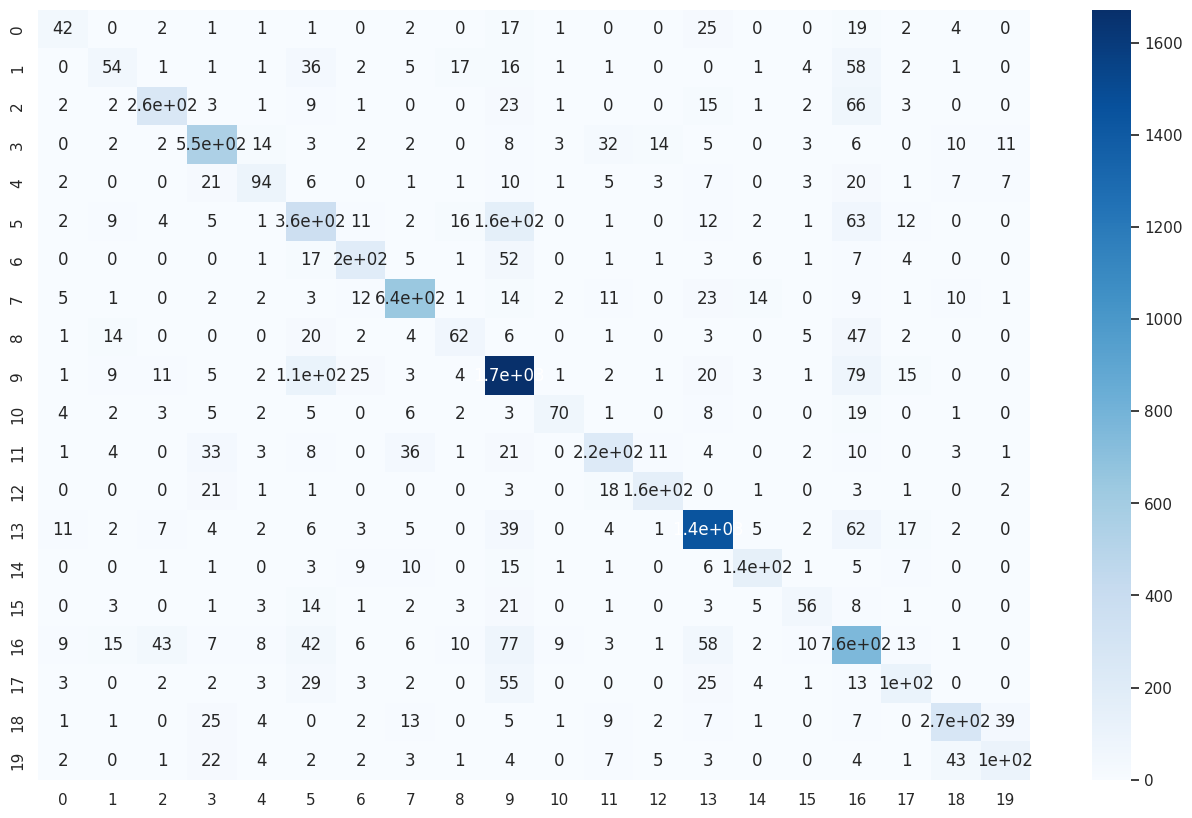

In [ ]:
conf_mat = confusion_matrix(y_test_sm, lr_cv_sm.predict(x_test_sm))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [ ]:
test_sizes = np.arange(.60, .95, .05)

train_scores = list()
test_scores = list()

for size in tqdm(test_sizes):
    x_train, x_test, y_train, y_test = train_test_split(df_pca, df['cuisine'], train_size=size, random_state=1, stratify=df['cuisine'])
    lr_cv = LogisticRegression().fit(x_train, y_train)

    train_scores.append(accuracy_score(y_train, lr_cv.predict(x_train)))
    test_scores.append(accuracy_score(y_test, lr_cv.predict(x_test)))

100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


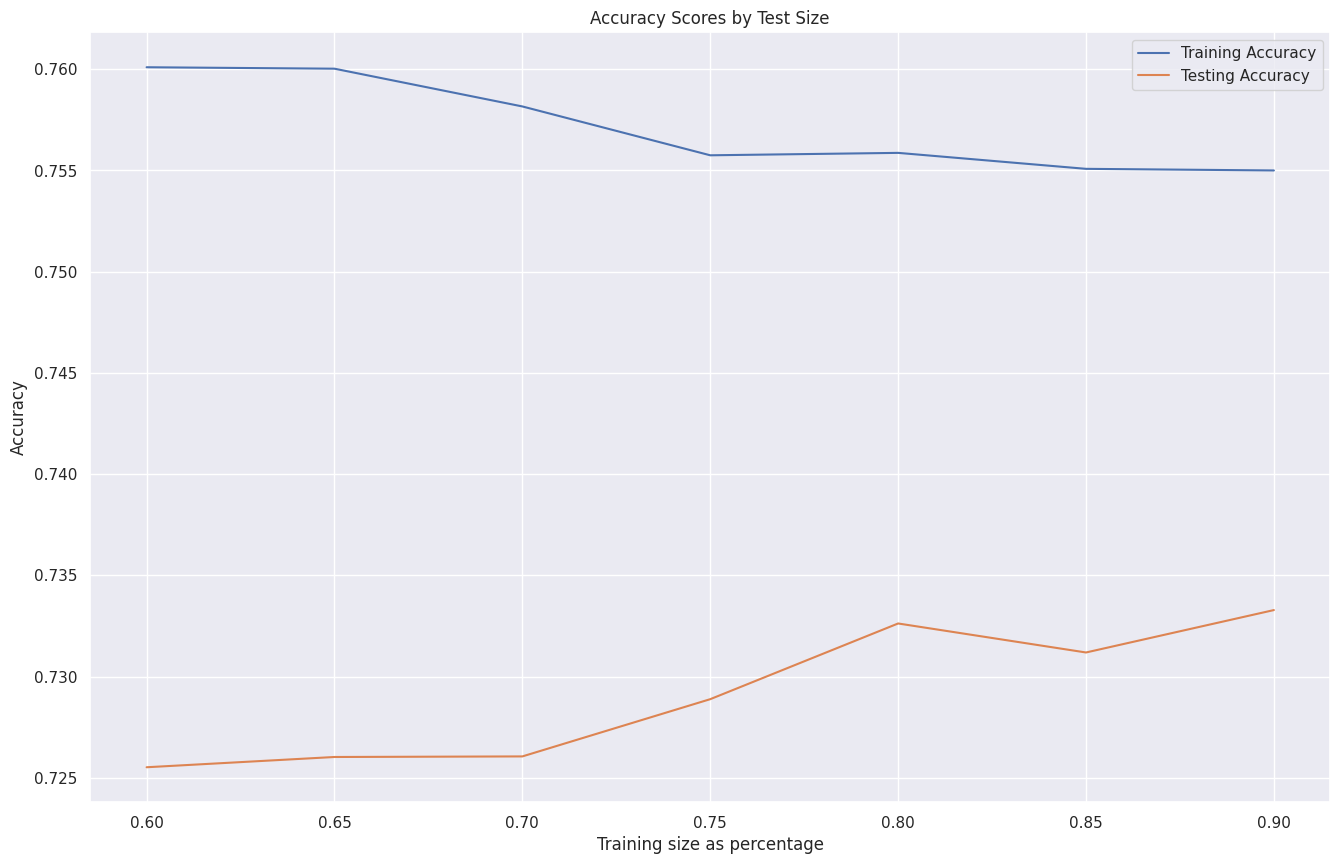

In [ ]:
# plot lines
plt.plot(test_sizes, train_scores, label = "Training Accuracy")
plt.plot(test_sizes, test_scores, label = "Testing Accuracy")
plt.xlabel("Training size as percentage")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores by Test Size")
plt.legend()
plt.show()